# Experiment - 2

Time to tackle the text-generation task.

In Experiment-1, I aimed to be as thorough as possible in my first real experience training a neural network for a specific task. For this experiment, I will take a more direct approach while reusing aspects of the previous one to streamline the process.

Engaging with the first task has given me valuable insight into the motives, methodology, and science of deep learning. My goal has always been to build a strong foundation and intuition about these concepts, rather than simply completing tasks. In the long run, I believe this approach will be more beneficial.

### Key Takeaways from CNNs & Neural Network Design

To build a neural network for a given task is to embed—or rather, program—the capabilities and logic the model requires into its **architecture**, **hyperparameters** and the **data** used to train it.

- ***Architecture*** refers to the structural design of the model—what components exist and how they are connected. This includes the type and number of layers (e.g., convolutional, recurrent, fully connected), the order and connections of layers (how data flows through them) and the choice of mathematical operations (activation functions, normalization layers, softmax).

- ***Hyperparameters*** are the configurable settings that define how the model learns and are not part of the model's fixed structure. These include Layer widths (number of neurons per layer), Dropout rate, Learning rate, Optimizer choices (Adam,SGD), Batch size and Regularization settings(such as Temperature in softmax).
    
- ***Data*** determines how much of the base architecture’s potential is realized. Its quality (variety, relevance) and quantity (dataset size) directly impact performance.

And the choice of these 3 pillars is closely linked— they work in tandem. Unlike the traditional programming I have experienced so far, where logic is explicitly coded, neural network engineering requires a more nuanced approach—one where experience and intuition play a crucial role. It blurs the boundary between science and art, a fusion I deeply enjoy, as I’ve expressed in my SoP.

In [1]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
import os
import torch
import random
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import datasets
from PIL import Image, ImageOps

# Character set
CHARACTERS = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"
char_to_idx = {char: idx + 1 for idx, char in enumerate(CHARACTERS)}  # Map chars to indices
char_to_idx["<BLANK>"] = 0  # blank label for CTC
idx_to_char = {idx: char for char, idx in char_to_idx.items()}

IMAGE_SIZE = (180,60)

# Function to apply augmentation (used for training data)
def apply_augmentation(image):
    angle = random.uniform(-5, 5)
    image = image.rotate(angle, expand=False, fillcolor="white")

    x_shift = random.randint(-5, 5)
    y_shift = random.randint(-5, 5)
    image = ImageOps.expand(image, border=(abs(x_shift), abs(y_shift)), fill="white")
    image = image.transform(
        IMAGE_SIZE,
        Image.AFFINE,
        (1, 0, -x_shift, 0, 1, -y_shift),
        fillcolor="white"
    )

    return image

class RandomAugmentation:
    def __call__(self, image):
        return apply_augmentation(image)

# Define transformations
train_transform = transforms.Compose([
    RandomAugmentation(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.ToTensor()
])


# Define dataset class
class GeneratorDataset(Dataset):
    def __init__(self, root_dir, allowed_classes=None, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform or transforms.ToTensor()

        # Iterate through all subdirectories (class names)
        for class_name in os.listdir(root_dir):
            if allowed_classes is not None and class_name not in allowed_classes:
                continue  # Skip classes not in the allowed set
                
            class_path = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_path):
                continue

            # Iterate through images in each class
            for img_name in os.listdir(class_path):
                if img_name.endswith(".png"):
                    img_path = os.path.join(class_path, img_name)

                    # Extract label from filename (before '_')
                    label_text = img_name.split("_")[0]  # Extract "diaMoND" from "diaMoND_-330776778599269819.png"
                    
                    self.image_paths.append(img_path)
                    self.labels.append(label_text)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("L")  # Convert to grayscale
        label_text = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        # Convert text label to sequence of character indices
        label_seq = torch.tensor([char_to_idx[char] for char in label_text], dtype=torch.long)

        return img, label_seq

In [5]:
# Define dataset paths
OUTPUT_DIR = "/kaggle/input/captcha-100"
easy_train_dir = os.path.join(OUTPUT_DIR, 'easy', 'train')
easy_test_dir = os.path.join(OUTPUT_DIR, 'easy', 'test')
hard_train_dir = os.path.join(OUTPUT_DIR, 'hard', 'train')
hard_test_dir = os.path.join(OUTPUT_DIR, 'hard', 'test')

def create_datasets():
    global easy_train_data, easy_test_data, hard_train_data, hard_test_data, class_names, combined_train_data, combined_test_data

    # Get all class names
    all_classes = (os.listdir(easy_train_dir))[:100]  # Restrict to 100 classes
    train_classes = set(all_classes[:80])  # First 80 classes for training
    test_classes = set(all_classes)  # All 100 classes for testing

    print(f"Training classes ({len(train_classes)}): {sorted(train_classes)}")
    print(f"Testing classes ({len(test_classes)}): {sorted(test_classes)}")

    # Apply augmentation for training data (restricted to first 90 classes)
    easy_train_data = GeneratorDataset(root_dir=easy_train_dir, allowed_classes=train_classes, transform=train_transform)
    hard_train_data = GeneratorDataset(root_dir=hard_train_dir, allowed_classes=train_classes, transform=train_transform)

    # No augmentation for test data (contains all 100 classes)
    easy_test_data = GeneratorDataset(root_dir=easy_test_dir, allowed_classes=test_classes, transform=test_transform)
    hard_test_data = GeneratorDataset(root_dir=hard_test_dir, allowed_classes=test_classes, transform=test_transform)

    class_names = sorted(list(train_classes))  # Get unique training class names

    # Combine datasets for training/testing
    combined_train_data = ConcatDataset([easy_train_data, hard_train_data])
    combined_test_data = ConcatDataset([easy_test_data, hard_test_data])

create_datasets()

# Function to extract metadata from ConcatDataset
def get_dataset_metadata(concat_dataset):
    """Extracts image paths and labels from all sub-datasets"""
    image_paths = []
    labels = []
    
    for dataset in concat_dataset.datasets:
        image_paths.extend(dataset.image_paths)
        labels.extend(dataset.labels)
        
    return image_paths, labels

# Get metadata from training data
train_image_paths, train_labels = get_dataset_metadata(combined_train_data)

# Print first 100 entries
print(f"Showing first {min(10, len(train_image_paths))} entries:\n")
for idx, (path, label) in enumerate(zip(train_image_paths[:10], train_labels[:10])):
    print(f"Entry #{idx+1}:")
    print(f"Image path: {path}")
    print(f"Label text: {label}")
    print(f"Label length: {len(label)} characters")
    print("-" * 50)

Training classes (80): ['Aanan', 'Akshat', 'Azure', 'Byzantine', 'Elijah', 'Emerald', 'Explicit', 'Gaming', 'Greek', 'Isabella', 'Kavin', 'Mia', 'Olivia', 'Ruby', 'Sapphire', 'Topaz', 'Ziggy', 'apple', 'attitude', 'black', 'blaze', 'cascade', 'copper', 'cosmic', 'cyber', 'cyclone', 'drizzle', 'echo', 'eclipse', 'ember', 'energy', 'frost', 'fusion', 'gale', 'glitch', 'golden', 'gravity', 'horizon', 'ignite', 'iron', 'learning', 'lightning', 'logic', 'luminous', 'machine', 'matrix', 'meadow', 'meteor', 'mirage', 'monsoon', 'neon', 'ocean', 'orbital', 'perhaps', 'phoenix', 'quantum', 'raven', 'shadow', 'slayer', 'solstice', 'spark', 'spectrum', 'spirit', 'steel', 'tempest', 'thunder', 'tide', 'tiger', 'titan', 'tundra', 'vector', 'verdant', 'vista', 'vivid', 'vortex', 'whirlwind', 'whisper', 'yellow', 'zenith', 'zephyr']
Testing classes (100): ['Aanan', 'Akshat', 'Aventurine', 'Azure', 'Byzantine', 'Diamond', 'Divit', 'Elijah', 'Emerald', 'Explicit', 'Gaming', 'Greek', 'Isabella', 'Kavin'

In [6]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

from torch.nn.utils.rnn import pad_sequence
def collate_fn(batch):
    images, label_seqs = zip(*batch)  # Unzip

    # Convert images to a single tensor 
    images = torch.stack(images)  

    # Flatten labels into a single tensor for CTC loss
    labels = torch.cat(label_seqs, dim=0)  

    # Compute target lengths (required for CTC Loss)
    target_lengths = torch.tensor([len(seq) for seq in label_seqs], dtype=torch.long)

    # LSTM processes features from CNN along width dimension (W = 22)
    batch_size, _, _, width = images.shape  # (B, C, H, W)
    input_lengths = torch.full(size=(batch_size,), fill_value=width, dtype=torch.long)  

    return images, labels, input_lengths, target_lengths

    
# Dataloaders
easy_train_dataloader, easy_test_dataloader = None, None
hard_train_dataloader, hard_test_dataloader = None, None
train_dataloader, test_dataloader = None, None

def create_dataloader():
    global easy_train_dataloader, easy_test_dataloader, hard_train_dataloader, hard_test_dataloader, train_dataloader, test_dataloader

    easy_train_dataloader = DataLoader(dataset=easy_train_data,
                                       batch_size=BATCH_SIZE,
                                       num_workers=NUM_WORKERS,
                                       shuffle=True
                                       ,collate_fn=collate_fn
                                      )

    easy_test_dataloader = DataLoader(dataset=easy_test_data,
                                      batch_size=BATCH_SIZE,
                                      num_workers=NUM_WORKERS,
                                      shuffle=False
                                      ,collate_fn=collate_fn
                                     )

    hard_train_dataloader = DataLoader(dataset=hard_train_data,
                                       batch_size=BATCH_SIZE,
                                       num_workers=NUM_WORKERS,
                                       shuffle=True
                                       ,collate_fn=collate_fn
                                      )

    hard_test_dataloader = DataLoader(dataset=hard_test_data,
                                      batch_size=BATCH_SIZE,
                                      num_workers=NUM_WORKERS,
                                      shuffle=False
                                      ,
                                      collate_fn=collate_fn
                                     )

    train_dataloader = DataLoader(dataset=combined_train_data,
                                  batch_size=BATCH_SIZE,
                                  num_workers=NUM_WORKERS,
                                  shuffle=True
                                  ,collate_fn=collate_fn
                                 )

    test_dataloader = DataLoader(dataset=combined_test_data,
                                 batch_size=BATCH_SIZE,
                                 num_workers=NUM_WORKERS,
                                 shuffle=False
                                 ,collate_fn=collate_fn
                                )

    print(f"Easy Train dataloader:\n{easy_train_dataloader}\nEasy Test dataloader:\n{easy_test_dataloader}\n"
          f"Hard Train dataloader:\n{hard_train_dataloader}\nHard Test dataloader:\n{hard_test_dataloader}\n"
          f"Train dataloader:\n{train_dataloader}\nTest dataloader:\n{test_dataloader}")

create_dataloader()


Easy Train dataloader:
Easy Test dataloader:
Hard Train dataloader:
Hard Test dataloader:
Train dataloader:
Test dataloader:


## Model Architecture: CRNN

1. **CNN**:

Following from the previous task, the input to the model is still image data and it would be best to continue using convolutional layers to extract spatial features from the image.

2. **RNN**:
   
In the previous task, the output was simply one of 100 classes which can be infered from the 100-wide output layer of a multi-layer perceptron classifier that processes the feature data obtained from the CNN layers.

Now the output is text of variable length. To choose a suitable **architecture** I must first identify the nature of the data and understand how it ought to be processed/generated. Text is sequential in nature: each character in the word has a particular character before it and after it and the sum of this alignment of sequential characters is the word itself. Thus this portion of the architecture (the one that acts on the image features to generate text) pertains to the process of sequence modeling: designing and training the model to handle sequential data.

Of the various architectures capable of sequence modeling, I must make a choice for my particular use case:
    - CNNs: Whilst CNNs are also used for certain sequence tasks, they don't possess inherent sequential capabilities. (Sequential nature isn't encoded into this architecture). In this [medium post](https://medium.com/@manvi./captcha-recognition-using-convolutional-neural-network-d191ef91330e) the author successfully achieves a similar task to my own using just CNNs, however limitations such as the inability of this approach to extract variable length CAPTCHAs make it inappropriate for my task.
    - Transformers: Transformers are driving the current LLM boom and I was able to know more about their working and applications thanks to the 3Blue1Brown Deep Learning playlist. Transformers are not the correct choice for my application as they simply outclass my requirment and are far too computationally intensive for the scope of this task.
    - RNNs (Recurrent Neural Networks) are inherently suited to handle sequential data and present a good fit for my use case. I may need to use a LSTM (Long Short-Term Memory) or GRU (Gated Recurrent Units) over a vanilla RNN, since they use gated cells to tackle the problem of vanishing gradients in RNNs. This gives them the ability to handle longer sequences. (The average word length for my dataset is 6.07 but the longer words are upto 12 characters long.

3. **CTC (Connectionist Temporal Classification) Loss**:
   
Unlike the classification task, we cannot use Cross Entropy Loss to train the model. Instead of having one label per input, the input(image) needs to be aligned to variable length output(text) and the characters do not have fixed positions in the image. There are also distortions, varying fonts and noise that prevent easy explicit segmentation (as was done in the previosuly linked mdeium post). CTC Loss eliminates the need of explicit character-to-image alignment— which is difficult and unreliable. I studied the details of the functioning and utility of CTC loss from this [blog post](https://distill.pub/2017/ctc/).
    

In [10]:
import torch.nn as nn
class Generator(nn.Module):
    def __init__(self, hidden_units: int, num_classes=len(CHARACTERS) + 1):  # +1 for CTC blank label
        super(Generator, self).__init__()
        
        # CNN Encoder
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=1,
                      out_channels=hidden_units,
                      kernel_size=3, 
                      stride=1,
                      padding=1), # Output: 60x180x24
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2), # Output: 30x90x24
            
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units*2,
                      kernel_size=3, 
                      stride=1,
                      padding=1), # Output: 30x90x48
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2), # Output: 15x45x48
            
            nn.Conv2d(in_channels=hidden_units*2,
                      out_channels=hidden_units*4,
                      kernel_size=3,
                      stride=1,
                      padding=1),  # Output: 15x45x96
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                          stride=2)  # Output: 7x22x96
        )

        # RNN Decoder
        self.rnn = nn.LSTM(input_size=hidden_units*4*7,
                           hidden_size=hidden_units*8,
                           num_layers=2, 
                           bidirectional=True, 
                           batch_first=True)
        self.fc = nn.Linear(hidden_units*8*2, num_classes)  # Bidirectional LSTM doubles output size

    def forward(self, x):
        features = self.cnn(x)  # (batch, hidden_units*4, H, W)
        features = features.permute(0, 3, 1, 2)  # (batch, W, C, H)
        features = features.flatten(2)  # (batch, W, C*H)
        # print(features.shape)
        rnn_out, _ = self.rnn(features)  # (batch, width, hidden_units*8*2)
        logits = self.fc(rnn_out)  # (batch, width, num_classes)
        return logits

# Instantiate model
# torch.manual_seed(69)
# model_0 = Generator(hidden_units= 24)
# print(model_0)


In [13]:
# Install/import torchinfo
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 1, 60, 180]) # do a test pass through of an example input size

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [1, 22, 53]               --
├─Sequential: 1-1                        [1, 96, 7, 22]            --
│    └─Conv2d: 2-1                       [1, 24, 60, 180]          240
│    └─ReLU: 2-2                         [1, 24, 60, 180]          --
│    └─MaxPool2d: 2-3                    [1, 24, 30, 90]           --
│    └─Conv2d: 2-4                       [1, 48, 30, 90]           10,416
│    └─ReLU: 2-5                         [1, 48, 30, 90]           --
│    └─MaxPool2d: 2-6                    [1, 48, 15, 45]           --
│    └─Conv2d: 2-7                       [1, 96, 15, 45]           41,568
│    └─ReLU: 2-8                         [1, 96, 15, 45]           --
│    └─MaxPool2d: 2-9                    [1, 96, 7, 22]            --
├─LSTM: 1-2                              [1, 22, 384]              2,217,984
├─Linear: 1-3                            [1, 22, 53]               20

In [21]:

# Define input image (grayscale, 60x180)
dummy_image = torch.randn(1, 1, 60, 180).to(device)  # (Batch=1, Channel=1, Height=60, Width=180)

# Instantiate model
torch.manual_seed(69)
model_0 = Generator(hidden_units=24).to(device)

# Forward pass
with torch.no_grad():
    output = model_0(dummy_image)

# Print shapes
print(f"Input shape: {dummy_image.shape}")  # Should be (1, 1, 60, 180)
print(f"Output shape: {output.shape}")  # Expected: (1, 22, num_classes)


Input shape: torch.Size([1, 1, 60, 180])
Output shape: torch.Size([1, 22, 53])


In [39]:
import torch.optim as optim

model_0 = Generator(hidden_units= 24).to(device)
# Define loss function and optimizer
criterion = nn.CTCLoss(blank=0, reduction = "mean")  # CTC loss
optimizer = optim.Adam(model_0.parameters(), lr=0.001)

# Training loop
model_0.train()
num_epochs = 30
for epoch in range(num_epochs):
    total_loss = 0
    for images, labels, input_lengths, target_lengths in easy_train_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        
        # Forward pass
        logits = model_0(images)  # (batch, width, num_classes)
        logits = logits.permute(1, 0, 2)  # Required shape for CTC: (seq_len, batch, num_classes)

        # Compute CTC loss
        batch_size = logits.size(1)
        input_lengths = torch.full((batch_size,), logits.size(0), dtype=torch.long, device=device)
        
        loss = criterion(logits.log_softmax(2), labels, input_lengths, target_lengths)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}")


Epoch 1/30, Loss: 65.8940
Epoch 2/30, Loss: 35.2106
Epoch 3/30, Loss: 34.4460
Epoch 4/30, Loss: 34.0579
Epoch 5/30, Loss: 33.8435
Epoch 6/30, Loss: 33.6756
Epoch 7/30, Loss: 33.4946
Epoch 8/30, Loss: 33.2702
Epoch 9/30, Loss: 33.0550
Epoch 10/30, Loss: 32.8883
Epoch 11/30, Loss: 32.7373
Epoch 12/30, Loss: 32.6094
Epoch 13/30, Loss: 32.5521
Epoch 14/30, Loss: 32.4873
Epoch 15/30, Loss: 32.3936
Epoch 16/30, Loss: 32.3215
Epoch 17/30, Loss: 32.1839
Epoch 18/30, Loss: 32.1540
Epoch 19/30, Loss: 32.0984
Epoch 20/30, Loss: 32.0721
Epoch 21/30, Loss: 32.0269
Epoch 22/30, Loss: 31.9963
Epoch 23/30, Loss: 31.9060
Epoch 24/30, Loss: 31.9020
Epoch 25/30, Loss: 31.8480
Epoch 26/30, Loss: 31.8446
Epoch 27/30, Loss: 31.7866
Epoch 28/30, Loss: 31.7249
Epoch 29/30, Loss: 31.6976
Epoch 30/30, Loss: 31.6798


In [40]:
optimizer = optim.Adam(model_0.parameters(), lr=0.001)
model_0.train()
num_epochs = 50    
# Decided upon after rounds of testing: Loss function slowly decreases -> manual interrupt at epoch 48. Fien tune by lowering learn rate.
for epoch in range(num_epochs):
    total_loss = 0
    for images, labels, input_lengths, target_lengths in hard_train_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        
        # Forward pass
        logits = model_0(images)  # (batch, width, num_classes)
        logits = logits.permute(1, 0, 2)  # Required shape for CTC: (seq_len, batch, num_classes)

        # Compute CTC loss
        batch_size = logits.size(1)
        input_lengths = torch.full((batch_size,), logits.size(0), dtype=torch.long, device=device)
        
        loss = criterion(logits.log_softmax(2), labels, input_lengths, target_lengths)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}")

Epoch 1/50, Loss: 735.0147
Epoch 2/50, Loss: 691.1839
Epoch 3/50, Loss: 650.3105
Epoch 4/50, Loss: 629.5377
Epoch 5/50, Loss: 615.5856
Epoch 6/50, Loss: 595.7975
Epoch 7/50, Loss: 560.6450
Epoch 8/50, Loss: 510.4230
Epoch 9/50, Loss: 439.2714
Epoch 10/50, Loss: 355.2609
Epoch 11/50, Loss: 269.5548
Epoch 12/50, Loss: 199.6192
Epoch 13/50, Loss: 150.0307
Epoch 14/50, Loss: 116.1492
Epoch 15/50, Loss: 88.1825
Epoch 16/50, Loss: 76.7623
Epoch 17/50, Loss: 64.1448
Epoch 18/50, Loss: 53.7784
Epoch 19/50, Loss: 47.0750
Epoch 20/50, Loss: 40.3807
Epoch 21/50, Loss: 37.0003
Epoch 22/50, Loss: 31.1540
Epoch 23/50, Loss: 27.4208
Epoch 24/50, Loss: 25.1596
Epoch 25/50, Loss: 19.9253
Epoch 26/50, Loss: 19.9257
Epoch 27/50, Loss: 16.5134
Epoch 28/50, Loss: 14.7553
Epoch 29/50, Loss: 15.9009
Epoch 30/50, Loss: 12.3494
Epoch 31/50, Loss: 12.7070
Epoch 32/50, Loss: 15.5130
Epoch 33/50, Loss: 8.8192
Epoch 34/50, Loss: 11.2895
Epoch 35/50, Loss: 15.3234
Epoch 36/50, Loss: 6.0873
Epoch 37/50, Loss: 5.6277

KeyboardInterrupt: 

In [13]:

def get_texts(logits):
    pred_indices = torch.argmax(logits, dim=2).tolist()  # shape: (batch, width)
    pred_texts = []
    for seq in pred_indices:
        text = "".join(idx_to_char[idx] for idx in seq if idx != 0)
        pred_texts.append(text)
    return pred_texts
    
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    model.eval()
    predictions = []
    with torch.inference_mode():
        for sample in data:
            # Prepare sample: add batch dimension and move to device
            sample = torch.unsqueeze(sample, dim=0).to(device)  # shape: (1, C, H, W)
            logits = model(sample)  # Expected shape: (1, width, num_classes)
            # Decode the prediction: assume decode_predictions returns a list of strings for a batch
            pred_text = get_texts(logits)[0]
            predictions.append(pred_text)
    return predictions

import random
import matplotlib.pyplot as plt

def test_random_samples(model: torch.nn.Module, full: bool, test: bool):
    test_samples = []
    test_labels = []
    
    if full:
        data_to_test = combined_test_data if test else combined_train_data
    else:
        data_to_test = easy_test_data if test else easy_train_data
        
    # Randomly select 36 samples
    for sample, label in random.sample(list(data_to_test), k=36):
        test_samples.append(sample)
        test_labels.append(label)
    
    # Get predictions (as list of strings) using the generator prediction function
    pred_texts = make_predictions(model=model, data=test_samples, device=device)
    
    # Plot the samples with predicted and true texts
    plt.figure(figsize=(9, 9))
    nrows = 12
    ncols = 3
    for i, sample in enumerate(test_samples):
        plt.subplot(nrows, ncols, i+1)
        
        # Plot image: if grayscale, squeeze channel dimension
        if sample.shape[0] == 1:
            plt.imshow(sample.squeeze(), cmap="gray")
        else:
            plt.imshow(sample.permute(1, 2, 0))
        
        # Decode the ground truth label (tensor to string)
        truth_text = "".join(idx_to_char[idx] for idx in test_labels[i].tolist())
        pred_text = pred_texts[i]
        
        title_text = f"Pred: {pred_text} | Truth: {truth_text}"
        
        # Set title color: green if prediction matches, else red
        if pred_text == truth_text:
            plt.title(title_text, fontsize=10, color="g")
        else:
            plt.title(title_text, fontsize=10, color="r")
        plt.axis("off")
    plt.show()

def plot_loss_curves(results: dict[str, list[float]]):
    """Plots training curves of a results dictionary.
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();


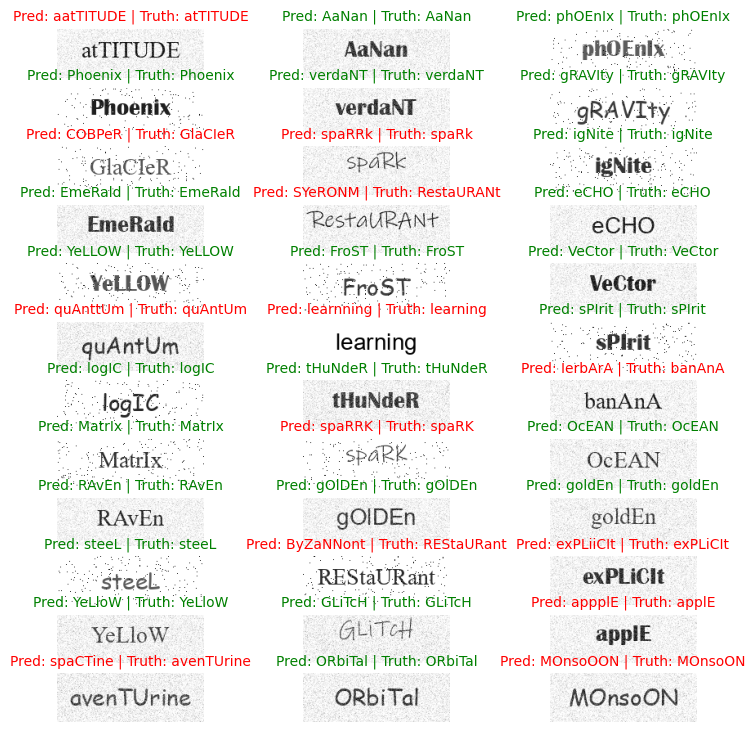

In [42]:
test_random_samples(model_0, True, True)

In [8]:
pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 42.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: click
    Found existing installation: click 8.1.7
    Uninstalling click-8.1.7:
      Successfully uninstalled click-8.1.7
Note: you may need to restart the kernel to use updated packages.


In [11]:
import torch.optim as optim
from tqdm.auto import tqdm
from jiwer import cer

# Helper: Decode predictions
def decode_predictions(logits):
    # Get predictions (we do not need softmax here since argmax is invariant to the normalization)
    logits = logits.permute(1, 0, 2)  # Bring batch to first dimension
    pred_indices = torch.argmax(logits, dim=2).tolist()  # shape: (batch, width)

    pred_texts = []
    for seq in pred_indices:
        # Convert indices to text while handling CTC blank removal
        text = []
        prev_idx = None
        for idx in seq:
            if idx != 0 and idx != prev_idx:  # Remove blanks and duplicates
                text.append(idx_to_char[idx])
            prev_idx = idx
        pred_texts.append("".join(text))
    return pred_texts

# Training Step: For one epoch over train data
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    model.train()
    total_loss, total_letter_acc = 0, 0
    
    for images, labels, input_lengths, target_lengths in dataloader:
        # Send images to device; labels remain as tensors of variable length
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass through CRNN; raw_logits shape: (batch, width, num_classes)
        logits = model(images)
        # For CTC loss, we need to apply log softmax and permute to (seq_len, batch, num_classes)
        logits = logits.permute(1, 0, 2).log_softmax(2)
        
        batch_size = logits.size(1)
        # Assume all outputs have the same sequence length (width of feature map)
        input_lengths = torch.full((batch_size,), logits.size(0), dtype=torch.long, device = device)
        
        # Compute CTC loss
        loss = loss_fn(logits, labels, input_lengths, target_lengths)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Decode predictions using raw_logits (shape: (batch, width, num_classes))
        pred_texts = decode_predictions(logits)
        # print(images.size(0), logits.size(1), len(pred_texts))
        # Compute letter accuracy for the batch: for each sample, letter_acc = 1 - cer(ref, hyp)
        split_labels = []
        start_idx = 0
        for length in target_lengths.tolist():
            # Extract the slice for this sample
            split_labels.append(labels[start_idx:start_idx + length])
            start_idx += length

        batch_letter_acc = 0
        for i, label in enumerate(split_labels):
            # Convert actual text tensor to text string
            actual_text = "".join(idx_to_char[idx.item()] for idx in label)
            # print(i)
            pred_text = pred_texts[i]
            sample_letter_acc = 1 - cer(actual_text, pred_text)
            batch_letter_acc += sample_letter_acc
        batch_letter_acc /= batch_size
        total_letter_acc += batch_letter_acc

    avg_loss = total_loss / len(dataloader)
    avg_letter_acc = total_letter_acc / len(dataloader)
    return avg_loss, avg_letter_acc


# Test Step: Evaluate on test data
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    model.eval()
    total_loss, total_letter_acc= 0, 0
    
    with torch.inference_mode():
        for images, labels,input_lengths, target_lengths in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            logits = model(images)
            logits = logits.permute(1, 0, 2).log_softmax(2)
            
            batch_size = logits.size(1)
            input_lengths = torch.full((batch_size,), logits.size(0), dtype=torch.long, device= device)
            # target_lengths = torch.tensor([len(label) for label in labels], dtype=torch.long)
            
            loss = loss_fn(logits, labels, input_lengths, target_lengths)
            total_loss += loss.item()
            
            pred_texts = decode_predictions(logits)

            split_labels = []
            start_idx = 0
            for length in target_lengths.tolist():
                # Extract the slice for this sample
                split_labels.append(labels[start_idx:start_idx + length])
                start_idx += length

            batch_letter_acc = 0
            for i, label in enumerate(split_labels):
                actual_text = "".join(idx_to_char[idx.item()] for idx in label)
                pred_text = pred_texts[i]
                sample_letter_acc = 1 - cer(actual_text, pred_text)
                batch_letter_acc += sample_letter_acc
            batch_letter_acc /= batch_size
            total_letter_acc += batch_letter_acc

    avg_loss = total_loss / len(dataloader)
    avg_letter_acc = total_letter_acc / len(dataloader)
    return avg_loss, avg_letter_acc

# Training Loop: Train and then evaluate each epoch
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CTCLoss(blank=0),
          epochs: int = 20):

    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader, 
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model= model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn)
        
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )
        
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
    return results


In [45]:
torch.manual_seed(69)
torch.cuda.manual_seed(69)

# Recreate an instance of the model
model_1 = Generator(hidden_units= 24).to(device)

loss_fn = nn.CTCLoss(blank=0)
optimizer = optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_1 on easy set
model_1_results = train(model=model_1,
                        train_dataloader=easy_train_dataloader,
                        test_dataloader=easy_test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=10)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 6.8007 | train_acc: 0.0000 | test_loss: 3.5179 | test_acc: 0.0000
Epoch: 2 | train_loss: 3.5348 | train_acc: 0.0000 | test_loss: 3.4727 | test_acc: 0.0000
Epoch: 3 | train_loss: 3.4530 | train_acc: 0.0000 | test_loss: 3.4098 | test_acc: 0.0000
Epoch: 4 | train_loss: 3.4005 | train_acc: 0.0000 | test_loss: 3.3836 | test_acc: 0.0000
Epoch: 5 | train_loss: 3.3766 | train_acc: 0.0000 | test_loss: 3.3725 | test_acc: 0.0000
Epoch: 6 | train_loss: 3.3561 | train_acc: 0.0000 | test_loss: 3.3500 | test_acc: 0.0000
Epoch: 7 | train_loss: 3.3424 | train_acc: 0.0000 | test_loss: 3.3381 | test_acc: 0.0000
Epoch: 8 | train_loss: 3.3230 | train_acc: 0.0000 | test_loss: 3.3214 | test_acc: 0.0000
Epoch: 9 | train_loss: 3.3082 | train_acc: 0.0000 | test_loss: 3.3121 | test_acc: 0.0000
Epoch: 10 | train_loss: 3.2985 | train_acc: 0.0000 | test_loss: 3.3149 | test_acc: 0.0000
Total training time: 7.183 seconds


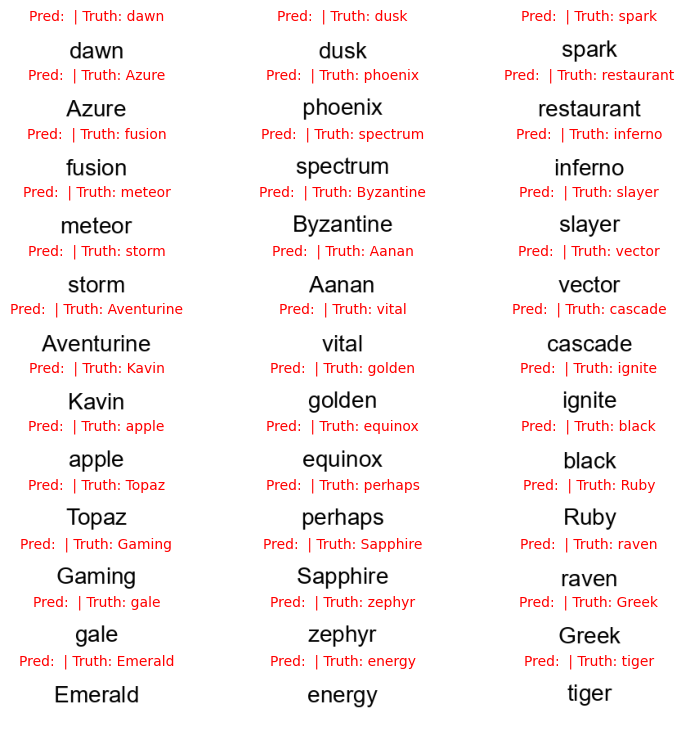

In [46]:
test_random_samples(model_1, False, True)

In [47]:
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)
start_time = timer()

# Train model_0 on hard set
model_1_results = train(model=model_1,
                        train_dataloader=hard_train_dataloader,
                        test_dataloader=hard_test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=40)

optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.0001)

model_1_fine_results = train(model=model_1,
                        train_dataloader=hard_train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=10)

for key in model_1_results:
  model_1_results[key] += model_1_fine_results[key]

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.8300 | train_acc: 0.0282 | test_loss: 3.6891 | test_acc: 0.1013
Epoch: 2 | train_loss: 3.4729 | train_acc: 0.1137 | test_loss: 3.5179 | test_acc: 0.1090
Epoch: 3 | train_loss: 3.3181 | train_acc: 0.1162 | test_loss: 3.4475 | test_acc: 0.1188
Epoch: 4 | train_loss: 3.2089 | train_acc: 0.1232 | test_loss: 3.3743 | test_acc: 0.1303
Epoch: 5 | train_loss: 2.9723 | train_acc: 0.1696 | test_loss: 3.0849 | test_acc: 0.1896
Epoch: 6 | train_loss: 2.6124 | train_acc: 0.2435 | test_loss: 2.7860 | test_acc: 0.2683
Epoch: 7 | train_loss: 2.1628 | train_acc: 0.3462 | test_loss: 2.3978 | test_acc: 0.3671
Epoch: 8 | train_loss: 1.6267 | train_acc: 0.4882 | test_loss: 1.9920 | test_acc: 0.4973
Epoch: 9 | train_loss: 1.1280 | train_acc: 0.6308 | test_loss: 1.7116 | test_acc: 0.5923
Epoch: 10 | train_loss: 0.7821 | train_acc: 0.7350 | test_loss: 1.5833 | test_acc: 0.6602
Epoch: 11 | train_loss: 0.5731 | train_acc: 0.7976 | test_loss: 1.4982 | test_acc: 0.6889
Epoch: 12 | train_l

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0099 | train_acc: 0.9982 | test_loss: 1.4512 | test_acc: 0.8429
Epoch: 2 | train_loss: 0.0072 | train_acc: 0.9988 | test_loss: 1.4651 | test_acc: 0.8427
Epoch: 3 | train_loss: 0.0072 | train_acc: 0.9990 | test_loss: 1.4626 | test_acc: 0.8438
Epoch: 4 | train_loss: 0.0051 | train_acc: 0.9994 | test_loss: 1.4651 | test_acc: 0.8438
Epoch: 5 | train_loss: 0.0052 | train_acc: 0.9992 | test_loss: 1.4640 | test_acc: 0.8438
Epoch: 6 | train_loss: 0.0047 | train_acc: 0.9994 | test_loss: 1.4609 | test_acc: 0.8433
Epoch: 7 | train_loss: 0.0045 | train_acc: 0.9994 | test_loss: 1.4760 | test_acc: 0.8425
Epoch: 8 | train_loss: 0.0050 | train_acc: 0.9992 | test_loss: 1.4887 | test_acc: 0.8429
Epoch: 9 | train_loss: 0.0039 | train_acc: 0.9996 | test_loss: 1.4836 | test_acc: 0.8421
Epoch: 10 | train_loss: 0.0042 | train_acc: 0.9993 | test_loss: 1.4743 | test_acc: 0.8431
Total training time: 406.613 seconds


Evidently, the model is overfitting. Test loss/accuracy stagnated after 20 epochs, and the train accuracy continued to soar. If I plot the loss curves, I expect to see a clear divergence between the train and test loss curves.

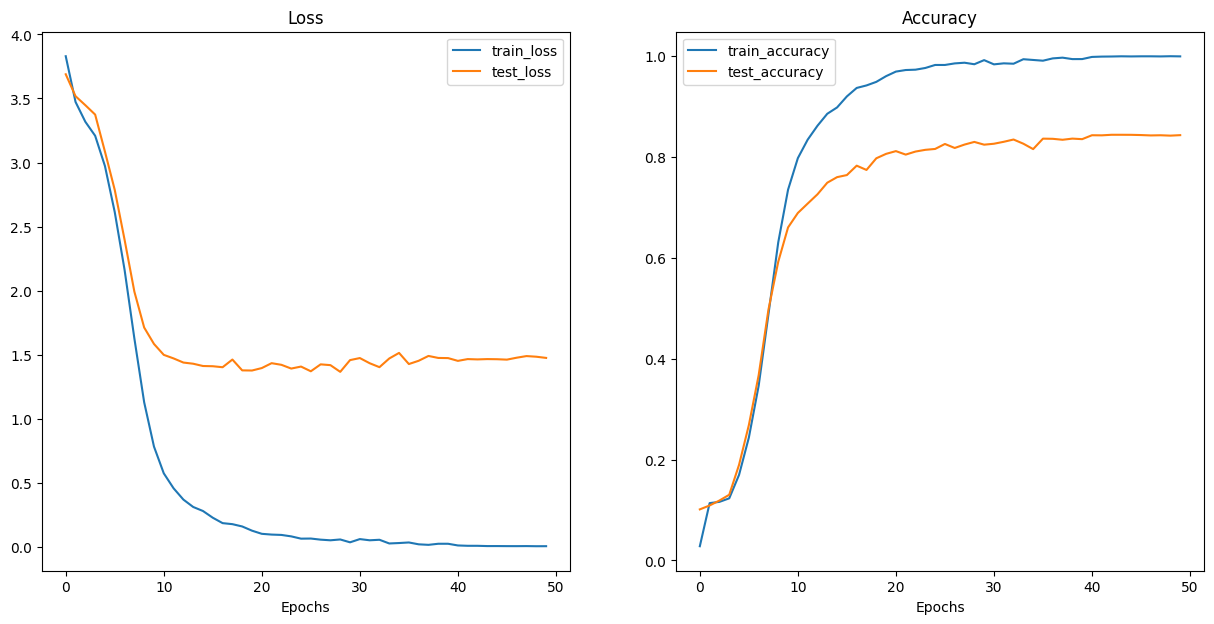

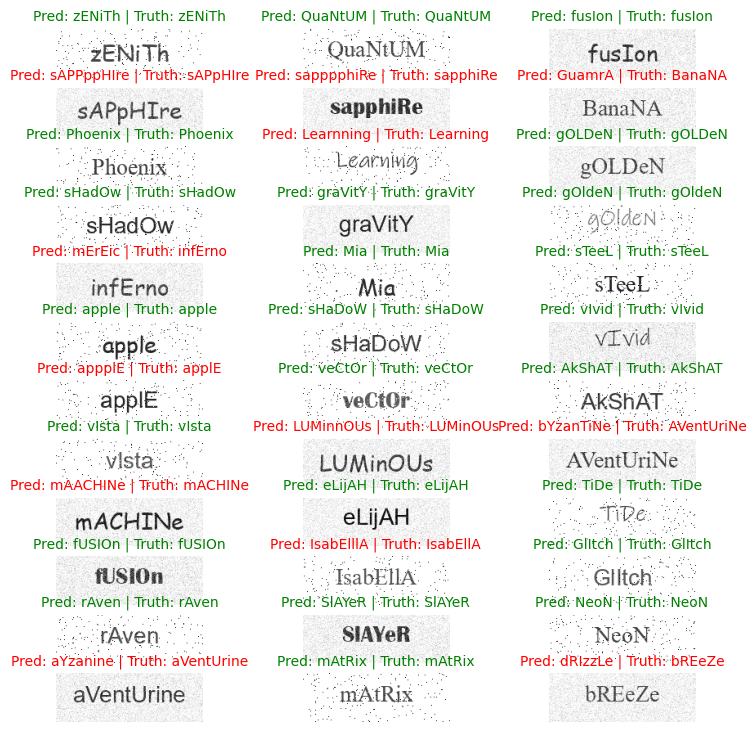

In [48]:
plot_loss_curves(model_1_results)
test_random_samples(model_1, True, True)

Still, at the very least we now have a model that has some capacity to extract text from images. (The pipeline works!)

I can identify two main problems teh model is currently facing when predicting on test data:
    - Confusing longer words like 'Byzantine' and 'Aventurine' that contain similar parts ('ine'), the model is memorizing certain patterns preferrentially.
    - Repeated letters are hard to distinguish. A single character is being spread over multiple slices without a blank in between. CTCLoss is used precisely to tackle this issue, however varying fonts and the lacking robustness/generalisation ability of the current model is holding the model back.



In [12]:
import torch.nn as nn
class Generator_2(nn.Module):
    def __init__(self, hidden_units: int, num_classes=len(CHARACTERS) + 1):  # +1 for CTC blank label
        super(Generator_2, self).__init__()
        
        # CNN Encoder
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=1,
                      out_channels=hidden_units,
                      kernel_size=3, 
                      stride=1,
                      padding=1), # Output: 60x180x24
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2), # Output: 30x90x24
            
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units*2,
                      kernel_size=3, 
                      stride=1,
                      padding=1), # Output: 30x90x48
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2), # Output: 15x45x48
            
            nn.Conv2d(in_channels=hidden_units*2,
                      out_channels=hidden_units*4,
                      kernel_size=3,
                      stride=1,
                      padding=1),  # Output: 15x45x96
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                          stride=2)  # Output: 7x22x96
        )

        # RNN Decoder
        self.rnn = nn.GRU(input_size=hidden_units*4*7,
                           hidden_size=hidden_units*8,
                           num_layers=2, 
                           bidirectional=True, 
                           batch_first=True,
                           )
        self.fc = nn.Linear(hidden_units*8*2, num_classes)  # Bidirectional RNN/LSTM/GRU doubles output size

    def forward(self, x):
        features = self.cnn(x)  # (batch, hidden_units*4, H, W)
        # print(features.shape)
        # features = features.mean(dim=2)
        features = features.permute(0, 3, 1, 2)  # (batch, W, C, H)
        features = features.flatten(2)  # (batch, W, C*H)
        # print(features.shape)
        # features = features.permute(0, 2, 1)  # Reshape to (batch, width, hidden_units*4)
        # print(features.shape)
        rnn_out, _ = self.rnn(features)  # (batch, width, hidden_units*8*2)
        logits = self.fc(rnn_out)  # (batch, width, num_classes)
        return logits

In [124]:
torch.manual_seed(69)
torch.cuda.manual_seed(69)

# Recreate an instance of the model
model_2 = Generator_2(hidden_units= 24).to(device)

loss_fn = nn.CTCLoss(blank=0, reduction='mean')
optimizer = optim.Adam(params=model_2.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_1 on easy set
model_2_results = train(model=model_2,
                        train_dataloader=easy_train_dataloader,
                        test_dataloader=easy_test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=10)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 6.0121 | train_acc: 0.0035 | test_loss: 3.7535 | test_acc: 0.0000
Epoch: 2 | train_loss: 3.5237 | train_acc: 0.0000 | test_loss: 3.4050 | test_acc: 0.0000
Epoch: 3 | train_loss: 3.3637 | train_acc: 0.0000 | test_loss: 3.3325 | test_acc: 0.0000
Epoch: 4 | train_loss: 3.3202 | train_acc: 0.0000 | test_loss: 3.3237 | test_acc: 0.0000
Epoch: 5 | train_loss: 3.2918 | train_acc: 0.0000 | test_loss: 3.2969 | test_acc: 0.0000
Epoch: 6 | train_loss: 3.2773 | train_acc: 0.0000 | test_loss: 3.2914 | test_acc: 0.0000
Epoch: 7 | train_loss: 3.2646 | train_acc: 0.0000 | test_loss: 3.2947 | test_acc: 0.0000
Epoch: 8 | train_loss: 3.2509 | train_acc: 0.0000 | test_loss: 3.2685 | test_acc: 0.0000
Epoch: 9 | train_loss: 3.2395 | train_acc: 0.0000 | test_loss: 3.2872 | test_acc: 0.0000
Epoch: 10 | train_loss: 3.2279 | train_acc: 0.0000 | test_loss: 3.2605 | test_acc: 0.0000
Total training time: 7.144 seconds


In [125]:
summary(model_2, input_size=[1, 1, 60, 180]) # do a test pass through of an example input size

Layer (type:depth-idx)                   Output Shape              Param #
Generator_2                              [1, 22, 53]               --
├─Sequential: 1-1                        [1, 96, 7, 22]            --
│    └─Conv2d: 2-1                       [1, 24, 60, 180]          240
│    └─ReLU: 2-2                         [1, 24, 60, 180]          --
│    └─MaxPool2d: 2-3                    [1, 24, 30, 90]           --
│    └─Conv2d: 2-4                       [1, 48, 30, 90]           10,416
│    └─ReLU: 2-5                         [1, 48, 30, 90]           --
│    └─MaxPool2d: 2-6                    [1, 48, 15, 45]           --
│    └─Conv2d: 2-7                       [1, 96, 15, 45]           41,568
│    └─ReLU: 2-8                         [1, 96, 15, 45]           --
│    └─MaxPool2d: 2-9                    [1, 96, 7, 22]            --
├─GRU: 1-2                               [1, 22, 384]              1,663,488
├─Linear: 1-3                            [1, 22, 53]               20

In [126]:
optimizer = torch.optim.Adam(params=model_2.parameters(), lr=0.001, weight_decay=1e-4)
start_time = timer()

# Train model_2 on hard set
model_2_results = train(model=model_2,
                        train_dataloader=hard_train_dataloader,
                        test_dataloader=hard_test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=45)

optimizer = torch.optim.Adam(params=model_2.parameters(), lr=0.0001, weight_decay=1e-4)

model_2_fine_results = train(model=model_2,
                        train_dataloader=hard_train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=10)

for key in model_2_results:
  model_2_results[key] += model_2_fine_results[key]

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.8447 | train_acc: 0.0365 | test_loss: 3.7926 | test_acc: 0.0772
Epoch: 2 | train_loss: 3.6402 | train_acc: 0.0907 | test_loss: 3.6524 | test_acc: 0.0951
Epoch: 3 | train_loss: 3.4747 | train_acc: 0.1142 | test_loss: 3.5501 | test_acc: 0.1192
Epoch: 4 | train_loss: 3.3744 | train_acc: 0.1166 | test_loss: 3.5307 | test_acc: 0.1138
Epoch: 5 | train_loss: 3.3014 | train_acc: 0.1210 | test_loss: 3.5035 | test_acc: 0.1349
Epoch: 6 | train_loss: 3.1967 | train_acc: 0.1360 | test_loss: 3.3601 | test_acc: 0.1473
Epoch: 7 | train_loss: 3.0796 | train_acc: 0.1539 | test_loss: 3.2962 | test_acc: 0.1527
Epoch: 8 | train_loss: 2.9856 | train_acc: 0.1695 | test_loss: 3.1808 | test_acc: 0.1682
Epoch: 9 | train_loss: 2.7954 | train_acc: 0.1981 | test_loss: 3.0167 | test_acc: 0.1920
Epoch: 10 | train_loss: 2.5389 | train_acc: 0.2547 | test_loss: 2.7526 | test_acc: 0.2658
Epoch: 11 | train_loss: 2.1396 | train_acc: 0.3661 | test_loss: 2.3195 | test_acc: 0.3933
Epoch: 12 | train_l

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0148 | train_acc: 0.9980 | test_loss: 0.9504 | test_acc: 0.8593
Epoch: 2 | train_loss: 0.0107 | train_acc: 0.9988 | test_loss: 0.9409 | test_acc: 0.8611
Epoch: 3 | train_loss: 0.0086 | train_acc: 0.9993 | test_loss: 0.9307 | test_acc: 0.8616
Epoch: 4 | train_loss: 0.0091 | train_acc: 0.9993 | test_loss: 0.9254 | test_acc: 0.8616
Epoch: 5 | train_loss: 0.0085 | train_acc: 0.9994 | test_loss: 0.9132 | test_acc: 0.8619
Epoch: 6 | train_loss: 0.0088 | train_acc: 0.9993 | test_loss: 0.9092 | test_acc: 0.8628
Epoch: 7 | train_loss: 0.0091 | train_acc: 0.9996 | test_loss: 0.9090 | test_acc: 0.8618
Epoch: 8 | train_loss: 0.0090 | train_acc: 0.9994 | test_loss: 0.9023 | test_acc: 0.8620
Epoch: 9 | train_loss: 0.0090 | train_acc: 0.9994 | test_loss: 0.9048 | test_acc: 0.8609
Epoch: 10 | train_loss: 0.0093 | train_acc: 0.9996 | test_loss: 0.8936 | test_acc: 0.8622
Total training time: 410.903 seconds


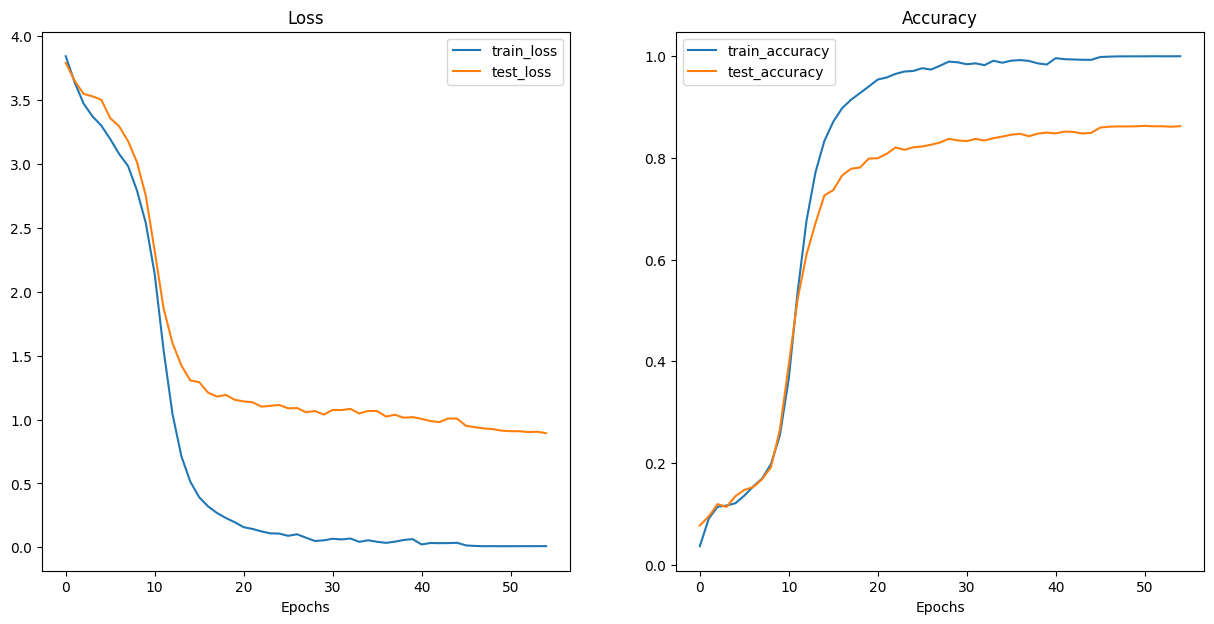

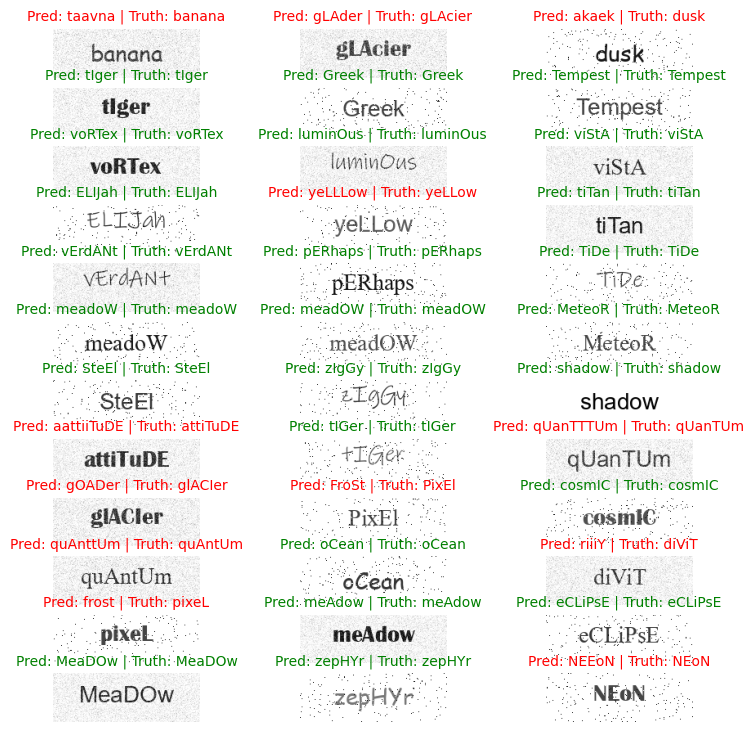

In [129]:
plot_loss_curves(model_2_results)
test_random_samples(model_2, True, True)

In [130]:
save_path = "/kaggle/working/generator.pth"

# Save model state_dict
torch.save(model_2.state_dict(), save_path)

6.382946395874024 0.22380952380952382


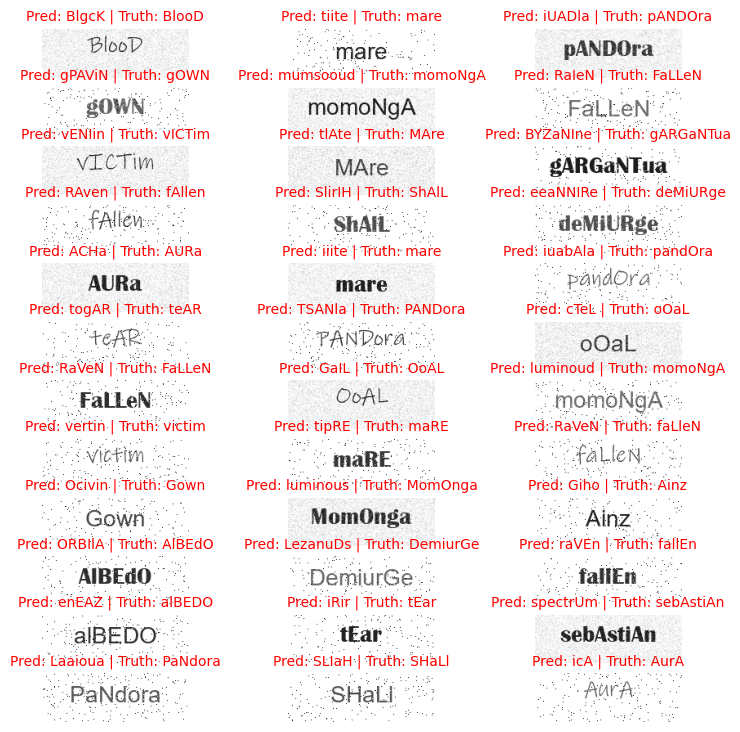

In [127]:
OUTPUT_DIR = "/kaggle/input/captcha-20-0"
eval_dir = os.path.join(OUTPUT_DIR, 'hard', 'train')

all_classes = (os.listdir(eval_dir)) 
test_classes = set(all_classes)  

# Apply augmentation for training data (restricted to first 90 classes)
eval_data = GeneratorDataset(root_dir=eval_dir, allowed_classes=test_classes, transform=test_transform)

eval_dataloader = DataLoader(dataset=eval_data,
                                      batch_size=BATCH_SIZE,
                                      num_workers=NUM_WORKERS,
                                      shuffle=False
                                      ,collate_fn=collate_fn)

loss, acc = test_step(model_1, eval_dataloader, loss_fn)
print(loss, acc)

test_samples = []
test_labels = []
    
for sample, label in random.sample(list(eval_data), k=36):
    test_samples.append(sample)
    test_labels.append(label)

# Get predictions (as list of strings) using the generator prediction function
pred_texts = make_predictions(model=model_1, data=test_samples, device=device)

# Plot the samples with predicted and true texts
plt.figure(figsize=(9, 9))
nrows = 12
ncols = 3
for i, sample in enumerate(test_samples):
    plt.subplot(nrows, ncols, i+1)
    
    # Plot image: if grayscale, squeeze channel dimension
    if sample.shape[0] == 1:
        plt.imshow(sample.squeeze(), cmap="gray")
    else:
        plt.imshow(sample.permute(1, 2, 0))
    
    # Decode the ground truth label (tensor to string)
    truth_text = "".join(idx_to_char[idx] for idx in test_labels[i].tolist())
    pred_text = pred_texts[i]
    
    title_text = f"Pred: {pred_text} | Truth: {truth_text}"
    
    # Set title color: green if prediction matches, else red
    if pred_text == truth_text:
        plt.title(title_text, fontsize=10, color="g")
    else:
        plt.title(title_text, fontsize=10, color="r")
    plt.axis("off")
plt.show()

In [22]:
OUTPUT_DIR = "/kaggle/input/captcha-10000-2"
big_train_dir = os.path.join(OUTPUT_DIR, 'hard', 'train')
big_test_dir = os.path.join(OUTPUT_DIR, 'hard', 'test')

# Get all class names
all_classes = (os.listdir(big_train_dir))  
train_classes = set(all_classes) 

big_train_data = GeneratorDataset(root_dir=big_train_dir, allowed_classes=train_classes, transform=test_transform)
big_test_data = GeneratorDataset(root_dir=big_test_dir, allowed_classes=train_classes, transform=test_transform)

big_train_dataloader = DataLoader(dataset=big_train_data,
                                       batch_size=BATCH_SIZE,
                                       num_workers=NUM_WORKERS,
                                       shuffle=True
                                       ,collate_fn=collate_fn
                                      )

big_test_dataloader = DataLoader(dataset=big_test_data,
                                      batch_size=BATCH_SIZE,
                                      num_workers=NUM_WORKERS,
                                      collate_fn=collate_fn
                                     )

In [24]:
torch.manual_seed(69)
torch.cuda.manual_seed(69)

# Recreate an instance of the model
model_3 = Generator_2(hidden_units= 24).to(device)

loss_fn = nn.CTCLoss(blank=0, reduction='mean')
optimizer = optim.Adam(params=model_3.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_3
model_3_results = train(model=model_3,
                        train_dataloader=big_train_dataloader,
                        test_dataloader=big_test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=20)

optimizer = torch.optim.Adam(params=model_3.parameters(), lr=0.0001, weight_decay=1e-4)


model_3_fine_results = train(model=model_3,
                        train_dataloader=big_train_dataloader,
                        test_dataloader=big_test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=10)

for key in model_3_results:
  model_3_results[key] += model_3_fine_results[key]

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.7405 | train_acc: 0.0849 | test_loss: 1.0878 | test_acc: 0.7287
Epoch: 2 | train_loss: 0.2935 | train_acc: 0.9444 | test_loss: 0.1490 | test_acc: 0.9773
Epoch: 3 | train_loss: 0.1194 | train_acc: 0.9808 | test_loss: 0.1059 | test_acc: 0.9830
Epoch: 4 | train_loss: 0.0834 | train_acc: 0.9857 | test_loss: 0.0976 | test_acc: 0.9834
Epoch: 5 | train_loss: 0.0633 | train_acc: 0.9886 | test_loss: 0.0866 | test_acc: 0.9843
Epoch: 6 | train_loss: 0.0499 | train_acc: 0.9905 | test_loss: 0.0791 | test_acc: 0.9862
Epoch: 7 | train_loss: 0.0393 | train_acc: 0.9918 | test_loss: 0.0706 | test_acc: 0.9871
Epoch: 8 | train_loss: 0.0291 | train_acc: 0.9936 | test_loss: 0.0775 | test_acc: 0.9861
Epoch: 9 | train_loss: 0.0241 | train_acc: 0.9943 | test_loss: 0.0726 | test_acc: 0.9878
Epoch: 10 | train_loss: 0.0187 | train_acc: 0.9955 | test_loss: 0.0764 | test_acc: 0.9866
Epoch: 11 | train_loss: 0.0136 | train_acc: 0.9966 | test_loss: 0.0793 | test_acc: 0.9867
Epoch: 12 | train_l

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0021 | train_acc: 0.9996 | test_loss: 0.0787 | test_acc: 0.9898
Epoch: 2 | train_loss: 0.0011 | train_acc: 1.0000 | test_loss: 0.0728 | test_acc: 0.9901
Epoch: 3 | train_loss: 0.0018 | train_acc: 1.0000 | test_loss: 0.0690 | test_acc: 0.9901
Epoch: 4 | train_loss: 0.0035 | train_acc: 0.9997 | test_loss: 0.0660 | test_acc: 0.9902
Epoch: 5 | train_loss: 0.0051 | train_acc: 0.9995 | test_loss: 0.0648 | test_acc: 0.9901
Epoch: 6 | train_loss: 0.0068 | train_acc: 0.9992 | test_loss: 0.0650 | test_acc: 0.9900
Epoch: 7 | train_loss: 0.0081 | train_acc: 0.9990 | test_loss: 0.0649 | test_acc: 0.9896
Epoch: 8 | train_loss: 0.0089 | train_acc: 0.9988 | test_loss: 0.0644 | test_acc: 0.9895
Epoch: 9 | train_loss: 0.0096 | train_acc: 0.9987 | test_loss: 0.0681 | test_acc: 0.9897
Epoch: 10 | train_loss: 0.0103 | train_acc: 0.9985 | test_loss: 0.0640 | test_acc: 0.9896
Total training time: 783.813 seconds


Here I observe a scenario where overfitting can be prevented by simply stopping training once it doesn't yield results/yields negative results. A better learning rate scheduling system and/or early stopping would help here.

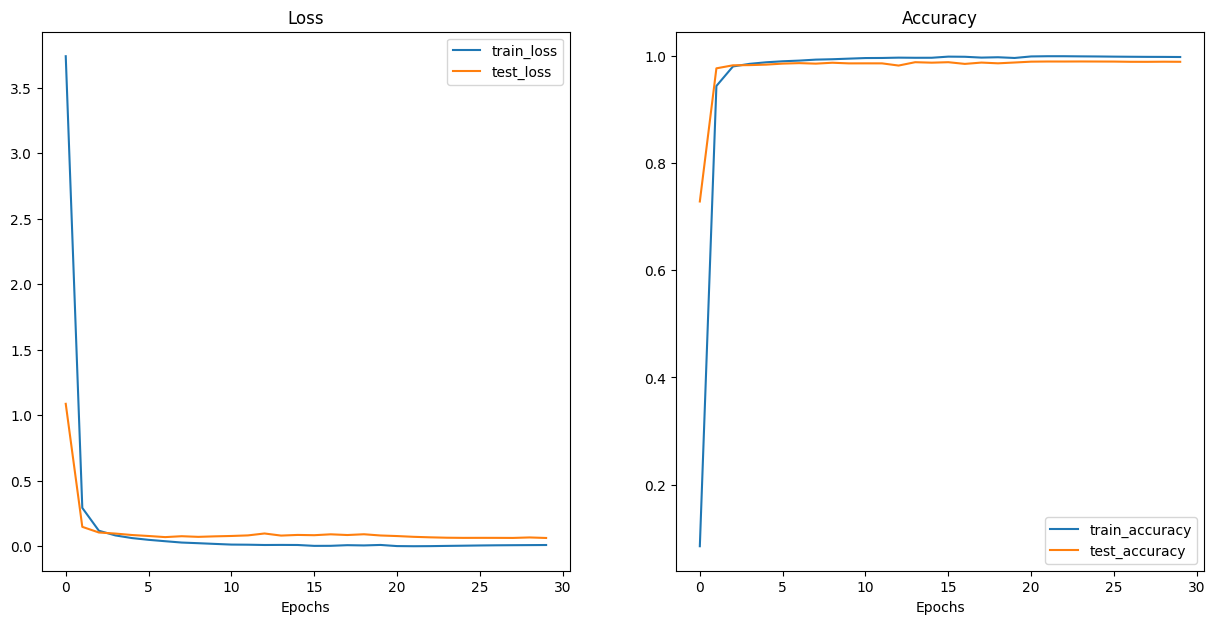

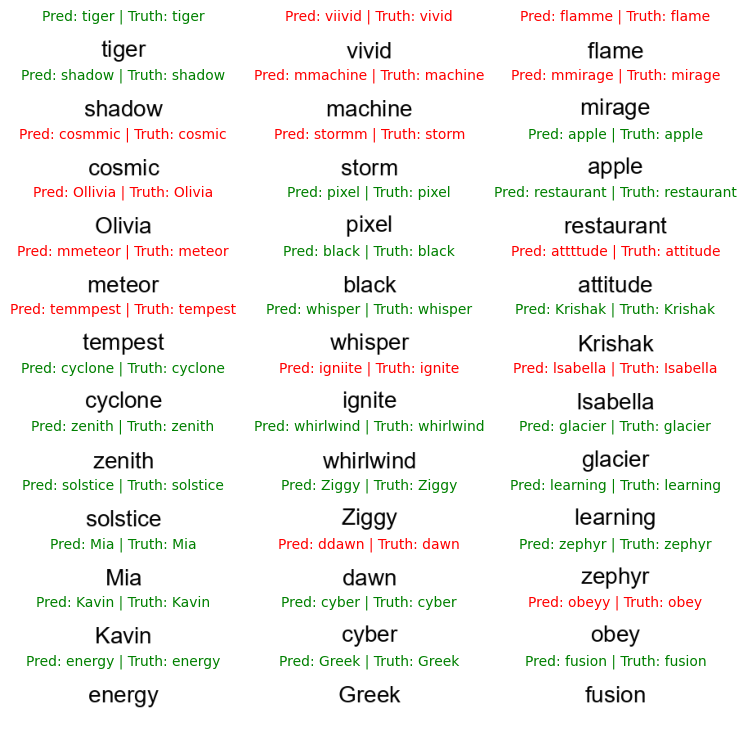

In [25]:
plot_loss_curves(model_3_results)
test_random_samples(model_3, False, True)

Here the new model_3 performs well considering these are words it hasn't explicitly been trained on (exactly what we want from OCR) and a considerable improvement from the models we trained on 100 classes. We can see that the CTC loss function is still strugglin to discredit wrong predictions of repeated words: perhaps expanding the dataset even more will help (more variation in fonts etc.)

Finally, there are cases such as the Isabella vs lsabella (with a lowercase 'l') as depicted here that are tricky even for the human eye.

6.021430397033692 0.08306795634920631


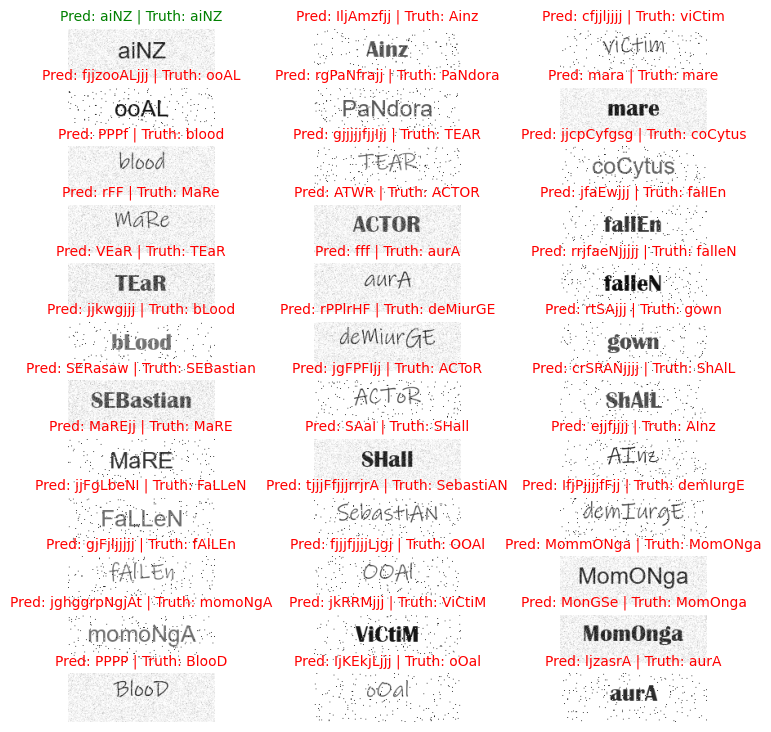

In [26]:
OUTPUT_DIR = "/kaggle/input/captcha-20-0"
eval_dir = os.path.join(OUTPUT_DIR, 'hard', 'train')

all_classes = (os.listdir(eval_dir)) 
test_classes = set(all_classes)  

# Apply augmentation for training data (restricted to first 90 classes)
eval_data = GeneratorDataset(root_dir=eval_dir, allowed_classes=test_classes, transform=test_transform)

eval_dataloader = DataLoader(dataset=eval_data,
                                      batch_size=BATCH_SIZE,
                                      num_workers=NUM_WORKERS,
                                      shuffle=False
                                      ,collate_fn=collate_fn)

loss, acc = test_step(model_3, eval_dataloader, loss_fn)
print(loss, acc)

test_samples = []
test_labels = []
    
for sample, label in random.sample(list(eval_data), k=36):
    test_samples.append(sample)
    test_labels.append(label)

# Get predictions (as list of strings) using the generator prediction function
pred_texts = make_predictions(model=model_3, data=test_samples, device=device)

# Plot the samples with predicted and true texts
plt.figure(figsize=(9, 9))
nrows = 12
ncols = 3
for i, sample in enumerate(test_samples):
    plt.subplot(nrows, ncols, i+1)
    
    # Plot image: if grayscale, squeeze channel dimension
    if sample.shape[0] == 1:
        plt.imshow(sample.squeeze(), cmap="gray")
    else:
        plt.imshow(sample.permute(1, 2, 0))
    
    # Decode the ground truth label (tensor to string)
    truth_text = "".join(idx_to_char[idx] for idx in test_labels[i].tolist())
    pred_text = pred_texts[i]
    
    title_text = f"Pred: {pred_text} | Truth: {truth_text}"
    
    # Set title color: green if prediction matches, else red
    if pred_text == truth_text:
        plt.title(title_text, fontsize=10, color="g")
    else:
        plt.title(title_text, fontsize=10, color="r")
    plt.axis("off")
plt.show()

model_3 struggles against varied fonts and augmentation.